# Step 1: Install Necessary Packages

In [1]:
pip install torch pandas numpy sentencepiece nltk gensim beautifulsoup4 scikit-learn joblib tqdm matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import sentencepiece as spm
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
import sys
import random
import json
import time
import itertools
import hashlib
import joblib
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
print("ROOT_DIR =", ROOT_DIR)  # should be .../dsa4213
sys.path.append(ROOT_DIR)

# set file paths and import necessary things
BASE_CKPT_DIR = os.path.join(ROOT_DIR, "Features", "encoding", "DistilBERT_pipeline", "best_ckpts_distilbert")
BASE_LORA_DIR = os.path.join(BASE_CKPT_DIR, "lora_weights")
BASE_LR_PATH = os.path.join(BASE_CKPT_DIR, "logistic_regression.pkl")
ABL_MODEL_PATH = os.path.join(BASE_CKPT_DIR, "hgb_model.pkl")

test_data_path = os.path.join(ROOT_DIR, "datasets", "encoder_dataset", "clean", "distilbert", "encoder_test_clean.csv")
cd_path = os.path.join(ROOT_DIR, "datasets", "cross_domain_dataset", "clean", "distilbert", "cross_domain_clean.csv")


ROOT_DIR = /Users/subhashree/Desktop/dsa4213


# Step 2: Reload DistilBERT Models & Test Data

In [ ]:
# Load test data
test_df = pd.read_csv(test_data_path)


class DistilBERT_LR_Evaluator:
    def __init__(self, lora_dir, lr_path):
        print(f"Loading tokenizer from HF...")
        self.tokenizer = DistilBertTokenizerFast.from_pretrained(
            "distilbert-base-uncased"
        )

        print(f"Loading DistilBERT + LoRA weights from {lora_dir}...")
        self.encoder = DistilBertModel.from_pretrained(lora_dir).to(device)
        self.encoder.eval()

        print(f"Loading Logistic Regression classifier from {lr_path}...")
        self.lr_clf = joblib.load(lr_path)

    def encode_texts(self, texts, batch_size=32):
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Encoding batches"):
                batch = texts[i:i+batch_size]
                enc = self.tokenizer(
                    batch, truncation=True, padding=True, max_length=128,
                    return_tensors="pt"
                ).to(device)

                outputs = self.encoder(**enc)
                cls_embedding = outputs.last_hidden_state[:, 0, :].cpu()
                embeddings.append(cls_embedding)

        return torch.cat(embeddings, dim=0).numpy()

    def predict(self, test_texts):
        X_test = self.encode_texts(test_texts)
        return self.lr_clf.predict(X_test)

    def predict_proba(self, test_texts):
        X_test = self.encode_texts(test_texts)
        return self.lr_clf.predict_proba(X_test)

# Load Models
print("\n" + "="*60)
print("LOADING MODELS")
print("="*60)

# Base model (DistilBERT + LoRA + LogReg)
print("\n[1/2] Loading Base Model...")
base_model = DistilBERT_LR_Evaluator(BASE_LORA_DIR, BASE_LR_PATH)

# Ablation model (DistilBERT + LoRA + Ablation Classifier)
print("\n[2/2] Loading Ablation Model...")
abl_model = DistilBERT_LR_Evaluator(BASE_LORA_DIR, ABL_MODEL_PATH)


# Prepare Test Data
texts = test_df["text_combined"].tolist()
test_labels_actual = test_df["label"].values


LOADING MODELS

[1/2] Loading Base Model...
Loading tokenizer from HF...
Loading DistilBERT + LoRA weights from /content/drive/My Drive/dsa4213 project/best_ckpts_distilbert/lora_weights...
Loading Logistic Regression classifier from /content/drive/My Drive/dsa4213 project/best_ckpts_distilbert/logistic_regression.pkl...

[2/2] Loading Ablation Model...
Loading tokenizer from HF...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading DistilBERT + LoRA weights from /content/drive/My Drive/dsa4213 project/best_ckpts_distilbert/lora_weights...
Loading Logistic Regression classifier from /content/drive/My Drive/dsa4213 project/hgb_model.pkl...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingClassifier from version 1.7.2 when using version 1.6.1. This might lead to breakin

# Step 3. Evaluation

## DistilBERT Base (LogReg) vs Ablation (HistBoost) Model

In [24]:
# Evaluate base model
print("\n" + "="*60)
print("EVALUATING BASE MODEL")
print("="*60)

base_preds = base_model.predict(texts)
base_pred_probs = base_model.predict_proba(texts)

base_acc = accuracy_score(test_labels_actual, base_preds)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    test_labels_actual, base_preds, average='weighted'
)
base_auc = roc_auc_score(test_labels_actual, base_pred_probs[:, 1])

# Evaluate ablation model
print("\n" + "="*60)
print("EVALUATING ABLATION MODEL")
print("="*60)

abl_preds = abl_model.predict(texts)
abl_pred_probs = abl_model.predict_proba(texts)

abl_acc = accuracy_score(test_labels_actual, abl_preds)
abl_prec, abl_rec, abl_f1, _ = precision_recall_fscore_support(
    test_labels_actual, abl_preds, average='weighted'
)
abl_auc = roc_auc_score(test_labels_actual, abl_pred_probs[:, 1])

# Model comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['DistilBERT + LogReg (Base)', 'DistilBERT + HistBoost (Ablation)'],
    'Accuracy': [base_acc, abl_acc],
    'Precision': [base_prec, abl_prec],
    'Recall': [base_rec, abl_rec],
    'F1-Score': [base_f1, abl_f1],
    'ROC-AUC': [base_auc, abl_auc],
})

print(comparison_df.to_string(index=False))

# improvements
print("\n" + "="*60)
print("ABLATION STUDY IMPROVEMENTS")
print("="*60)
print(f"Accuracy:  {(abl_acc - base_acc)*100:+.2f}%")
print(f"Precision: {(abl_prec - base_prec)*100:+.2f}%")
print(f"Recall:    {(abl_rec - base_rec)*100:+.2f}%")
print(f"F1-Score:  {(abl_f1 - base_f1)*100:+.2f}%")
print(f"ROC-AUC:   {(abl_auc - base_auc)*100:+.2f}%")


EVALUATING BASE MODEL


Encoding batches: 100%|██████████| 252/252 [00:36<00:00,  6.98it/s]



EVALUATING ABLATION MODEL


Encoding batches: 100%|██████████| 252/252 [00:37<00:00,  6.81it/s]



MODEL COMPARISON
                            Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
       DistilBERT + LogReg (Base)  0.991063   0.991072 0.991063  0.991061 0.998684
DistilBERT + HistBoost (Ablation)  0.990938   0.990945 0.990938  0.990937 0.997341

ABLATION STUDY IMPROVEMENTS
Accuracy:  -0.01%
Precision: -0.01%
Recall:    -0.01%
F1-Score:  -0.01%
ROC-AUC:   -0.13%



GENERATING CONFUSION MATRICES


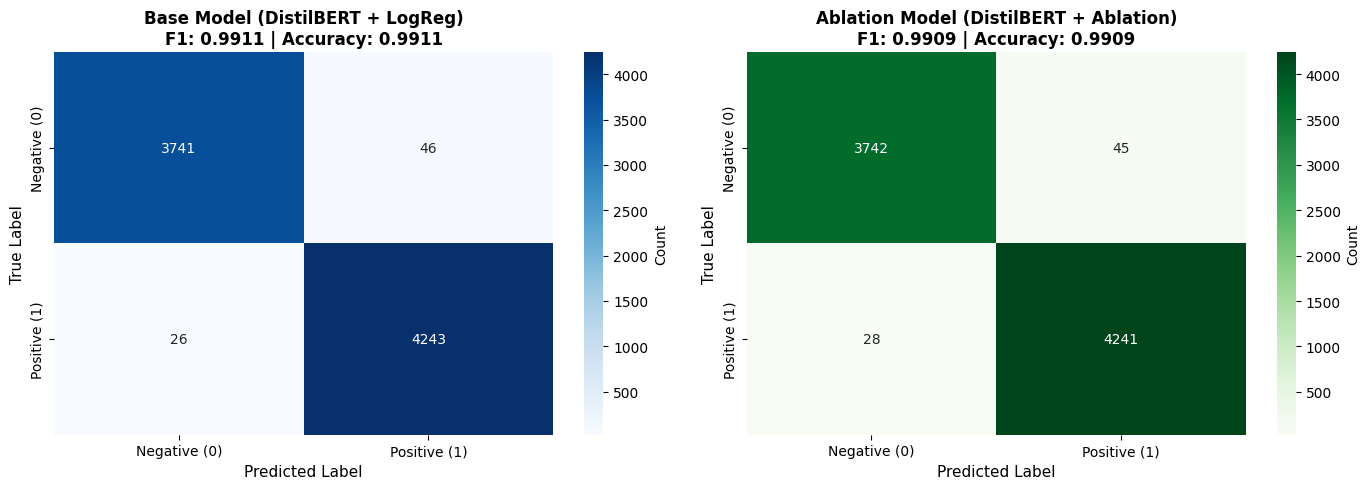


BASE MODEL — MISCLASSIFICATION ANALYSIS

Examples of FALSE POSITIVES (legitimate marked as scam):

212. Probability: 0.845
Text: bibi email pb yahoo com...

285. Probability: 0.578
Text: apple cknsinsideappleapplecom introducing apple tv movie rentals direct tv httpinsideappleapplecomredircbxcgidov2atljrvltnopstcfiwb6ithompo2bhltlrt2bkhoih8vs26zw9zdeagb6vay6z9thhmewr9lu2bjkas8tpnwlset...

458. Probability: 1.000
Text: gift web site http ww barrington ltd com...


Examples of FALSE NEGATIVES (spam that got through):

260. Probability: 0.000
Text: gage osborn mmssbluewinch bringing best home entertainment systems august offers panasonic th6spfloek charcoal including year warranty units purchased august price includes panasonic year manufacturer...

386. Probability: 0.002
Text: stocks uptrend boston daily investor lert llc expect several earthshaking news releases week next earnings driven short term target much higher tradestar corporation tirr next big mover current price ...

722. Pr

In [25]:
# Confusion matrix analysis
print("\n" + "="*60)
print("GENERATING CONFUSION MATRICES")
print("="*60)

# Calculate the confusion matrices for both models
base_cm = confusion_matrix(test_labels_actual, base_preds)
abl_cm = confusion_matrix(test_labels_actual, abl_preds)

# Plotting the confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Base Model Confusion Matrix
sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Base Model (DistilBERT + LogReg)\nF1: {base_f1:.4f} | Accuracy: {base_acc:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[0].set_yticklabels(['Negative (0)', 'Positive (1)'])

# Ablation Model Confusion Matrix
sns.heatmap(abl_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'Ablation Model (DistilBERT + Ablation)\nF1: {abl_f1:.4f} | Accuracy: {abl_acc:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[1].set_yticklabels(['Negative (0)', 'Positive (1)'])

plt.tight_layout()
plt.show()

def show_fp_fn_simple(preds, probs, y_true, texts, model_name):
    print("\n" + "="*60)
    print(f"{model_name} — MISCLASSIFICATION ANALYSIS")
    print("="*60)

    preds = np.array(preds)
    y_true = np.array(y_true)
    scam_proba = probs[:, 1]   # probability of class 1 (scam)

    # False Positives = marked scam but actually legit
    fp = np.where((preds == 1) & (y_true == 0))[0]

    # False Negatives = marked legit but actually scam
    fn = np.where((preds == 0) & (y_true == 1))[0]

    # ---- FALSE POSITIVES ----
    print("\nExamples of FALSE POSITIVES (legitimate marked as scam):")
    if len(fp) == 0:
        print("None.")
    else:
        for i in fp[:3]:
            print(f"\n{i}. Probability: {scam_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

    # ---- FALSE NEGATIVES ----
    print("\n\nExamples of FALSE NEGATIVES (spam that got through):")
    if len(fn) == 0:
        print("None.")
    else:
        for i in fn[:3]:
            print(f"\n{i}. Probability: {scam_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

show_fp_fn_simple(base_preds, base_pred_probs, test_labels_actual, texts, "BASE MODEL")
show_fp_fn_simple(abl_preds, abl_pred_probs, test_labels_actual, texts, "ABLATION MODEL")

# Step 4: Cross Domain Testing

## DistilBERT Base (LogReg) vs Ablation (HistBoost) Model

In [ ]:
# 1. LOAD CROSS-DOMAIN DATASET
print("\n" + "="*60)
print("LOADING CROSS-DOMAIN DATA")
print("="*60)

df = pd.read_csv(cd_path)

df = df.dropna(subset=["cleaned", "label"])
df["cleaned"] = df["cleaned"].astype(str).str.strip()
df = df[df["cleaned"] != ""]
df = df.reset_index(drop=True)

texts = df["cleaned"].tolist()
labels = df["label"].tolist()

print(f"Loaded {len(df)} cleaned samples.")


# 2. DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 3. PATHS
# set at the start

# 4. DISTILBERT + LORA ENCODER
class DistilBERT_LoRA_Encoder:
    def __init__(self, lora_dir):
        print("Loading tokenizer...")
        self.tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

        print("Loading DistilBERT + LoRA encoder...")
        self.encoder = DistilBertModel.from_pretrained(lora_dir).to(device)
        self.encoder.eval()

    def encode(self, texts, batch_size=32):
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Encoding batches"):
                batch = texts[i:i+batch_size]
                enc = self.tokenizer(
                    batch, truncation=True, padding=True, max_length=128,
                    return_tensors="pt"
                ).to(device)

                out = self.encoder(**enc)
                cls_embeds = out.last_hidden_state[:, 0, :].cpu()
                embeddings.append(cls_embeds)

        return torch.cat(embeddings, dim=0).numpy()


# 5. LOAD MODELS
print("\n" + "="*60)
print("LOADING MODELS")
print("="*60)

encoder = DistilBERT_LoRA_Encoder(BASE_LORA_DIR)

print("Loading Base Model (Logistic Regression)...")
base_clf = joblib.load(BASE_LR_PATH)

print("Loading Ablation Model (HistBoost)...")
abl_clf = joblib.load(ABL_MODEL_PATH)


# 6. ENCODE TEXTS
print("\n" + "="*60)
print("ENCODING TEXTS")
print("="*60)

X_test = encoder.encode(texts)


LOADING CROSS-DOMAIN DATA
Loaded 5092 cleaned samples.
Using device: cuda

LOADING MODELS
Loading tokenizer...
Loading DistilBERT + LoRA encoder...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.6.1. This might lead to breaking code or in

Loading Base Model (Logistic Regression)...
Loading Ablation Model (HistBoost)...

ENCODING TEXTS


Encoding batches: 100%|██████████| 160/160 [00:09<00:00, 17.35it/s]


In [19]:
# 7. EVALUATION FUNCTION
def evaluate_model(model, X, y_true):
    preds = model.predict(X)
    probs = model.predict_proba(X)

    acc = accuracy_score(y_true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average="weighted")
    auc = roc_auc_score(y_true, probs[:, 1])
    cm = confusion_matrix(y_true, preds)

    return preds, probs, acc, prec, rec, f1, auc, cm


# 8. RUN EVALS
print("\nEvaluating BASE MODEL...")
base_preds, base_probs, base_acc, base_prec, base_rec, base_f1, base_auc, base_cm = \
    evaluate_model(base_clf, X_test, labels)

print("\nEvaluating ABLATION MODEL...")
abl_preds, abl_probs, abl_acc, abl_prec, abl_rec, abl_f1, abl_auc, abl_cm = \
    evaluate_model(abl_clf, X_test, labels)


# 9. MODEL COMPARISON TABLE
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    "Model": ["DistilBERT + LogReg (Base)", "DistilBERT + HistBoost (Ablation)"],
    "Accuracy": [base_acc, abl_acc],
    "Precision": [base_prec, abl_prec],
    "Recall": [base_rec, abl_rec],
    "F1": [base_f1, abl_f1],
    "ROC-AUC": [base_auc, abl_auc],
})

print(comparison_df.to_string(index=False))


Evaluating BASE MODEL...

Evaluating ABLATION MODEL...

MODEL COMPARISON
                            Model  Accuracy  Precision   Recall       F1  ROC-AUC
       DistilBERT + LogReg (Base)  0.358602   0.871245 0.358602 0.416396 0.785712
DistilBERT + HistBoost (Ablation)  0.337588   0.871747 0.337588 0.389102 0.783473



 Base Model Confusion Matrix


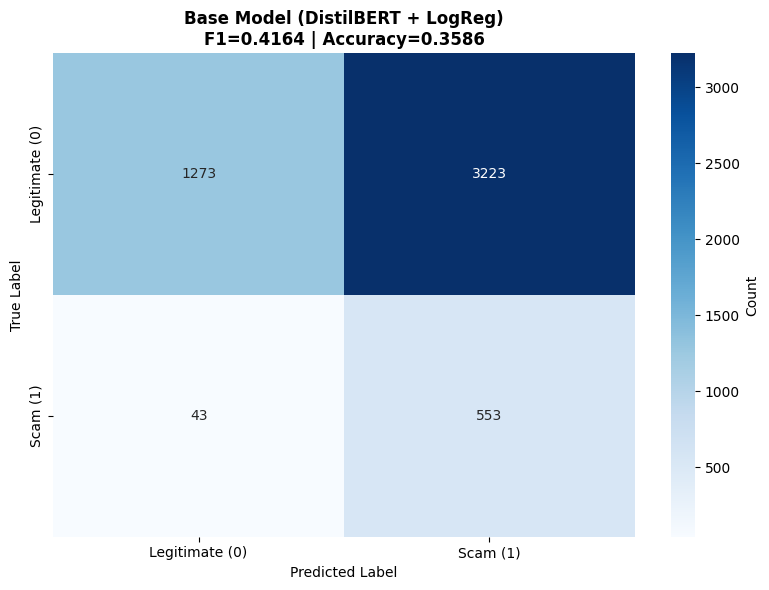


 Ablation Model Confusion Matrix


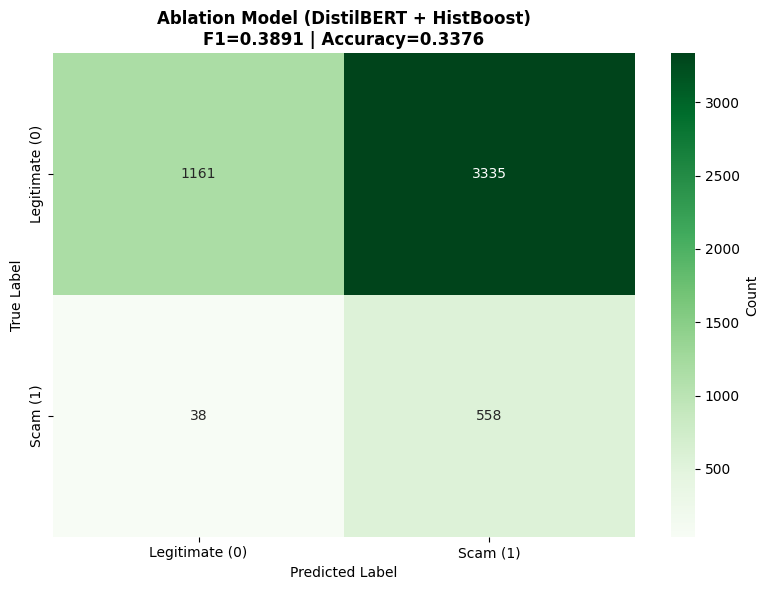


FALSE POSITIVES / FALSE NEGATIVES — BASE MODEL

Examples of FALSE POSITIVES (legitimate → scam):

Index: 0
Probability Scam: 1.000
Text: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat...

Index: 1
Probability Scam: 1.000
Text: ok lar joking wif u oni...

Index: 3
Probability Scam: 0.996
Text: u dun say so early hor u c already then say...

Examples of FALSE NEGATIVES (scam → legitimate):

Index: 54
Probability Scam: 0.015
Text: sms ac sptv the new jersey devils and the detroit red wings play ice hockey correct or incorrect end reply end sptv...

Index: 121
Probability Scam: 0.411
Text: todays voda numbers ending are selected to receive a <money> award if you have a match please call quoting claim code standard rates app...

Index: 188
Probability Scam: 0.070
Text: are you unique enough find out from eoth august <url>...

FALSE POSITIVES / FALSE NEGATIVES — ABLATION MODEL

Examples of FALSE POSITIVES (legitimate → scam):

Index: 0

In [20]:

# 10. CONFUSION MATRICES
def plot_cm(cm, title, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                cbar_kws={'label': 'Count'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Legitimate (0)', 'Scam (1)'])
    ax.set_yticklabels(['Legitimate (0)', 'Scam (1)'])
    plt.tight_layout()
    plt.show()

print("\n Base Model Confusion Matrix")
plot_cm(
    base_cm,
    f"Base Model (DistilBERT + LogReg)\nF1={base_f1:.4f} | Accuracy={base_acc:.4f}",
    cmap='Blues'
)

print("\n Ablation Model Confusion Matrix")
plot_cm(
    abl_cm,
    f"Ablation Model (DistilBERT + HistBoost)\nF1={abl_f1:.4f} | Accuracy={abl_acc:.4f}",
    cmap='Greens'
)


# 11. MISCLASSIFICATION ANALYSIS (FP / FN)
def show_fp_fn_style(preds, probs, y_true, texts, model_name):
    print("\n" + "="*60)
    print(f"FALSE POSITIVES / FALSE NEGATIVES — {model_name}")
    print("="*60)

    y_pred = np.array(preds)
    y_true = np.array(y_true)
    y_proba = probs[:, 1]  # scam probability

    # FP = predicted scam (1) but true = legitimate (0)
    fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]

    # FN = predicted legitimate (0) but true = scam (1)
    fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]

    print("\nExamples of FALSE POSITIVES (legitimate → scam):")
    if len(fp_indices) == 0:
        print("None found.")
    else:
        for i in fp_indices[:3]:
            print(f"\nIndex: {i}")
            print(f"Probability Scam: {y_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

    print("\nExamples of FALSE NEGATIVES (scam → legitimate):")
    if len(fn_indices) == 0:
        print("None found.")
    else:
        for i in fn_indices[:3]:
            print(f"\nIndex: {i}")
            print(f"Probability Scam: {y_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

# Base model
show_fp_fn_style(base_preds, base_probs, labels, texts, "BASE MODEL")

# Ablation model
show_fp_fn_style(abl_preds, abl_probs, labels, texts, "ABLATION MODEL")